In [2]:
import math
from functools import partial

import torch
import torch.nn as nn

import warnings

In [3]:
import matplotlib.pyplot as plt

def plot_one_slice(img, cmap = 'gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()

## Load Numpy arrays and plot histograms

In [4]:
import os
import numpy as np

folder_path = "../cohort_new/numpy arrays"
file_list = os.listdir(folder_path)

data_list = []
for file_name in file_list:
    if file_name.endswith('.npy'):
        file_path = os.path.join(folder_path, file_name)  # Construct the full file path
        array = np.load(file_path).astype(float)          # Load the array and convert its type to float
        data_list.append(array) 

In [5]:
# Squeeze the arrays to remove the redundant dimension
data_list = [arr.squeeze() for arr in data_list]

In [6]:
heights = [arr.shape[1] for arr in data_list]
widths = [arr.shape[2] for arr in data_list]
slices = [arr.shape[0] for arr in data_list]

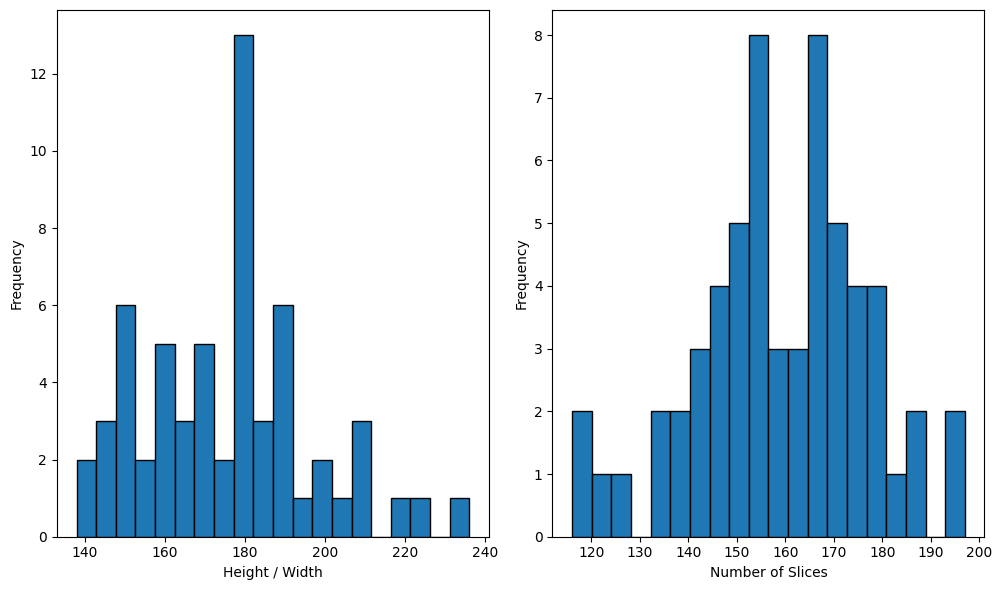

In [7]:
import matplotlib.pyplot as plt

# Create histograms of the heights, widths and slices

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.hist(heights, bins=20, edgecolor='black')
plt.xlabel('Height / Width')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(slices, bins=20, edgecolor='black')
plt.xlabel('Number of Slices')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

croping for slices
zero padding and croping for x,y

----

## Edit PatachEmbed Class in vision_transformer.py for 3D volumes

Function in the `vision_transformer.py` file.

In [8]:
from scipy.ndimage import zoom

In [20]:
class PatchEmbed_3D(nn.Module):
    def __init__(self, volume_size=(147, 224, 224), patch_size=(7, 16, 16), in_channels=1, embed_dim=64):
        super().__init__()
        num_patches = (volume_size[0] // patch_size[0]) * (volume_size[1] // patch_size[1]) * (volume_size[2] // patch_size[2])
        self.volume_size = volume_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, D, H, W = x.shape
        print(self.proj(x).shape)
        print(self.proj(x).flatten(2).shape)
        x = self.proj(x).flatten(2).transpose(1, 2)

        return x

In [10]:
sample = data_list[0]
print('Selected 3D scan size:', sample.shape)

Selected 3D scan size: (147, 171, 171)


* We want to convert the array to size (147 x 224 x 224) and so to use patch size of (7, 16, 16) for projection.

In [11]:
# Convert sample size to 147 x 224 x 224

# Set the desired output size
output_size = (147, 224, 224)

# Calculate the zoom factors for each dimension
zoom_factors = (output_size[0] / sample.shape[0],
                output_size[1] / sample.shape[1],
                output_size[2] / sample.shape[2])

# Resize the array using zoom
output_volume_array = zoom(sample, zoom_factors, order=1)

In [12]:
print('Modified array size:', output_volume_array.shape)

Modified array size: (147, 224, 224)


In [13]:
# Convert the array to a PyTorch tensor
output_volume_tensor = torch.from_numpy(output_volume_array).unsqueeze(0).unsqueeze(0).float()

In [14]:
output_volume_tensor.shape

torch.Size([1, 1, 147, 224, 224])

In [21]:
# Create a PatchEmbed_3D object
pathch_embed_3d = PatchEmbed_3D(volume_size=(147, 224, 224), patch_size=(7, 16, 16), in_channels=1, embed_dim=64)
# Forward pass the tensor through the PatchEmbed_3D object to get the 3D projection
projection_3d = pathch_embed_3d.forward(output_volume_tensor)

torch.Size([1, 64, 21, 14, 14])
torch.Size([1, 64, 4116])


In [15]:
print('Projection output size:', projection_3d.shape)

Projection output size: torch.Size([1, 4116, 64])


In [16]:
print('Number of patches:', pathch_embed_3d.num_patches)

Number of patches: 4116


---

## Edit RECHead class in the vision_transformer.py for 3D volumes

* **Q:** Do we need CLSHead ?? what is used for?!

* **NOTE:** We hard coded the out_sz for now, we should change it later!

* in_dim is set to be embed_dim in the main.py.

In [17]:
# This is just a copy of the original version of the functions!

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        tensor.uniform_(2 * l - 1, 2 * u - 1)

        tensor.erfinv_()

        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

In [18]:
class RECHead_3D(nn.Module):
    def __init__(self, in_dim, in_chans=1, patch_size=(7, 16, 16)):
        super().__init__()

        layers = [nn.Linear(in_dim, in_dim)]
        layers.append(nn.GELU())
        layers.append(nn.Linear(in_dim, in_dim))
        layers.append(nn.GELU())
        layers.append(nn.Linear(in_dim, in_dim))
        layers.append(nn.GELU())

        self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        
        self.convTrans = nn.ConvTranspose3d(in_dim, in_chans, kernel_size=patch_size, 
                                                stride=patch_size)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        
        x_rec = x.transpose(1, 2)
        #out_sz = tuple( (  int(math.sqrt(x_rec.size()[2]))  ,   int(math.sqrt(x_rec.size()[2])) ) )
        out_sz = tuple( (21, 14, 14) ) # hard coded for now
        x_rec = self.convTrans(x_rec.unflatten(2, out_sz))
                
                
        return x_rec

In [19]:
projection_3d.shape

torch.Size([1, 4116, 64])

In [228]:
RECHead_3D(64).forward(projection_3d).shape

torch.Size([1, 1, 147, 224, 224])

## Modify VisionTransformer function in the vision_transformer.py

* **Q:** Should we change the `self.cls_token`, `self.pos_embed`??

* **Q:** What is the `cls_token` ?!

* **Q:** How to change `interpolate_pos_encoding` function?! What is this use for?

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, volume_size=(147, 224, 224), patch_size=(7,16,16), in_chans=1, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed_3D(
            volume_size=volume_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Sequential(*[nn.Linear(2*embed_dim, embed_dim), nn.GELU(), nn.Linear(embed_dim, num_classes)]) if num_classes > 0 else nn.Identity()


        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, d, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        d0 = d // self.patch_embed.patch_size[0] # New
        w0 = w // self.patch_embed.patch_size[1]
        h0 = h // self.patch_embed.patch_size[2]
        d0, w0, h0 = d0 + 0.1, w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(d0) == patch_pos_embed.shape[-3] and int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, d, w, h = x.shape
        x = self.patch_embed(x)  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.interpolate_pos_encoding(x, d, w, h)

        return self.pos_drop(x)

    def forward(self, x, classify=False):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        
        if classify==True:
            return self.head( torch.cat( (x[:, 0], torch.mean(x[:, 1:], dim=1)), dim=1 ) )   

        return x

In [164]:
test_tensor = torch.zeros(1, 1, 64)

In [165]:
test_tensor.shape

torch.Size([1, 1, 64])

## Edit GMML_drop_rand_patches function in dataset_utils.py for 3D volumes

* **Q:** Which augmentations do we want to keep?

In [98]:
def GMML_drop_rand_patches_3d(X, X_rep=None, drop_type='noise', max_replace=0.7, align=(7, 16, 16), max_block_sz=0.3):
    import torch
    import numpy as np
    from random import randint

    #######################
    # max_replace: percentage of image to be replaced
    # align: align corruption with the patch sizes
    # max_block_sz: percentage of the maximum block to be dropped
    #######################

    torch.manual_seed(0)
    np.random.seed(0)

    C, D, H, W = X.size()
    n_drop_pix = np.random.uniform(min(0.5, max_replace), max_replace) * D * H * W
    mx_blk_depth = int(D * max_block_sz)
    mx_blk_height = int(H * max_block_sz)
    mx_blk_width = int(W * max_block_sz)

    align_d, align_h, align_w = align

    #align = max(1, align)

    mask = torch.zeros_like(X)
    drop_t = np.random.choice(drop_type.split('-'))

    while mask[0].sum() < n_drop_pix:

        ####### get a random block to replace
        rnd_e = (randint(0, D - align_d) // align_d) * align_d
        rnd_r = (randint(0, H - align_h) // align_h) * align_h
        rnd_c = (randint(0, W - align_w) // align_w) * align_w

        rnd_d = min(randint(align_d, mx_blk_depth), D - rnd_e)
        rnd_d = round(rnd_d / align_d) * align_d
        rnd_h = min(randint(align_h, mx_blk_height), H - rnd_r)
        rnd_h = round(rnd_h / align_h) * align_h
        rnd_w = min(randint(align_w, mx_blk_width), W - rnd_c)
        rnd_w = round(rnd_w / align_w) * align_w

        if X_rep is not None:
            X[:, rnd_e:rnd_e + rnd_d, rnd_r:rnd_r + rnd_h, rnd_c:rnd_c + rnd_w] = X_rep[:,
                                                                                  rnd_e:rnd_e + rnd_d,
                                                                                  rnd_r:rnd_r + rnd_h,
                                                                                  rnd_c:rnd_c + rnd_w].detach().clone()
        else:
            if drop_t == 'noise':
                X[:, rnd_e:rnd_e + rnd_d, rnd_r:rnd_r + rnd_h, rnd_c:rnd_c + rnd_w] = torch.empty(
                    (C, rnd_d, rnd_h, rnd_w), dtype=X.dtype, device=X.device).normal_()
            elif drop_t == 'zeros':
                X[:, rnd_e:rnd_e + rnd_d, rnd_r:rnd_r + rnd_h, rnd_c:rnd_c + rnd_w] = torch.zeros(
                    (C, rnd_d, rnd_h, rnd_w), dtype=X.dtype, device=X.device)
            else:
                ####### get a random block to replace from
                rnd_e2 = (randint(0, D - rnd_d) // align_d) * align_d
                rnd_r2 = (randint(0, H - rnd_h) // align_h) * align_h
                rnd_c2 = (randint(0, W - rnd_w) // align_w) * align_w

                X[:, rnd_e:rnd_e + rnd_d, rnd_r:rnd_r + rnd_h, rnd_c:rnd_c + rnd_w] = X[:,
                                                                                      rnd_e2:rnd_e2 + rnd_d,
                                                                                      rnd_r2:rnd_r2 + rnd_h,
                                                                                      rnd_c2:rnd_c2 + rnd_w].detach().clone()

        mask[:, rnd_e:rnd_e + rnd_d, rnd_r:rnd_r + rnd_h, rnd_c:rnd_c + rnd_w] = 1

    return X, mask


In [99]:
output_volume_tensor.squeeze(0).shape

torch.Size([1, 147, 224, 224])

In [100]:
X, mask = GMML_drop_rand_patches_3d(output_volume_tensor.squeeze(0))

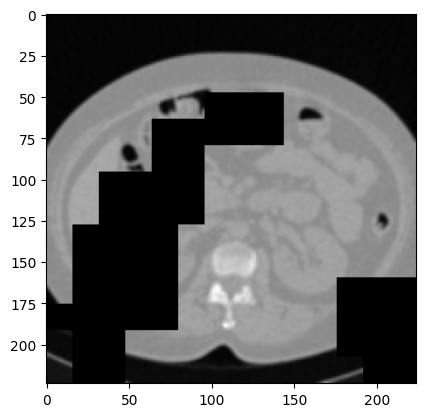

In [114]:
plot_one_slice(X.squeeze(0)[0], cmap='gray')

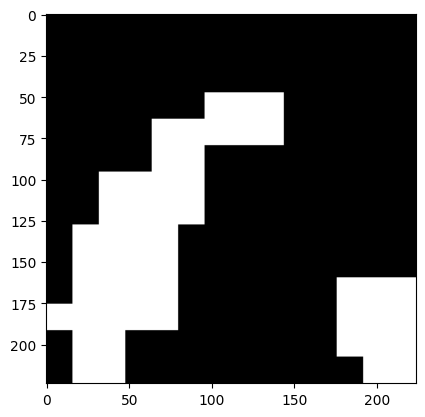

In [115]:
plot_one_slice(mask.squeeze(0)[0], cmap='gray')

-----

## Edit GMML_replace_list function in datasets_utils.py for 3D volumes

In [108]:
import random
from random import randint

from torchvision import transforms


In [ ]:
def GMML_replace_list(samples, corrup_prev, masks_prev, drop_type='noise', max_replace=0.35, align=(7, 16, 16)):
        
    rep_drop = 1 if drop_type == '' else ( 1 / ( len(drop_type.split('-')) + 1 ) )
    
    n_volumes = samples.size()[0] #this is batch size, but in case bad inistance happened while loading
    samples_aug = samples.detach().clone()
    masks = torch.zeros_like(samples_aug)
    for i in range(n_volumes):
        idx_rnd = randint(0, n_volumes)
        if random.random() < rep_drop: 
            samples_aug[i], masks[i] = GMML_drop_rand_patches_3d(samples_aug[i], samples[idx_rnd], max_replace=max_replace, align=align)
        else:
            samples_aug[i], masks[i] = corrup_prev[i], masks_prev[i]

    return samples_aug, masks

## Edit DataAugmentationSiT in datasets_utils.py for 3D volumes

**Note:** The function is supposed to implement two augmentations and clean_crops, corrupted_crops, and masks_crops for each. <br>**Q:** Why do we need two augmentations? We pass it to the teacher and student, But WHY?!

**Transformation to be used:**
<br>horizontal flipping: We can use torchvision.transforms.RandomHorizontalFlip for 3D tensors
<br>rotation around z: torchvision.transforms.RandomRotation
<br>scaling (uniformly - 5%) (for 3D)

In [148]:
class DataAugmentationSiT(object):
    def __init__(self, args):
        
        # for corruption
        self.drop_perc = args.drop_perc
        self.drop_type = args.drop_type
        self.drop_align = args.drop_align
        
        
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
        #    transforms.RandomResizedCrop(224, scale=(0.2, 1.), interpolation=Image.BICUBIC),
        #    flip_and_color_jitter,
        #    GaussianBlur(1.0),
        #    normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
        #    transforms.RandomResizedCrop(224, scale=(0.2, 1.), interpolation=Image.BICUBIC),
        #    flip_and_color_jitter,
        #    GaussianBlur(0.1),
        #    Solarization(0.2),
        #    normalize,
        ])

    def __call__(self, image):
        
        clean_crops = []
        corrupted_crops = []
        masks_crops = []

        ## augmented 1
        im_orig = self.global_transfo1(image)

        im_corrupted = im_orig.detach().clone()
        im_mask = torch.zeros_like(im_corrupted)
        if self.drop_perc > 0:
            im_corrupted, im_mask = GMML_drop_rand_patches_3d(im_corrupted, 
                                                           max_replace=self.drop_perc, drop_type=self.drop_type, align=self.drop_align)
        clean_crops.append(im_orig)
        corrupted_crops.append(im_corrupted)
        masks_crops.append(im_mask)
        
        ## augmented 2
        im_orig = self.global_transfo2(image)
        
        im_corrupted = im_orig.detach().clone()
        im_mask = torch.zeros_like(im_corrupted)
        if self.drop_perc > 0:
            im_corrupted, im_mask = GMML_drop_rand_patches_3d(im_corrupted, 
                                                           max_replace=self.drop_perc, drop_type=self.drop_type, align=self.drop_align)
        clean_crops.append(im_orig)
        corrupted_crops.append(im_corrupted)
        masks_crops.append(im_mask)
        
        return clean_crops, corrupted_crops, masks_crops



In [149]:
import argparse

args = argparse.Namespace(drop_perc=0.35, drop_type='noise', drop_align=(7, 16, 16))
data_augmentation = DataAugmentationSiT(args)


In [22]:
output_volume_tensor.squeeze(0).shape

torch.Size([1, 147, 224, 224])

In [150]:
clean_crops, corrupted_crops, masks_crops = data_augmentation(output_volume_tensor.squeeze(0))


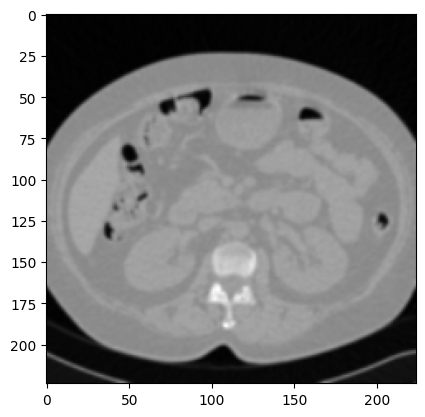

In [151]:
plot_one_slice(output_volume_tensor.squeeze(0).squeeze(0)[0], cmap='gray')

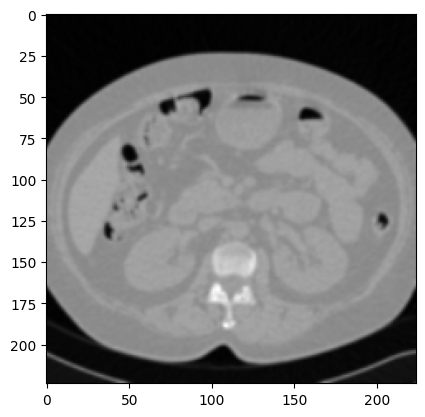

In [157]:
plot_one_slice(clean_crops[0].squeeze(0)[0], cmap='gray')

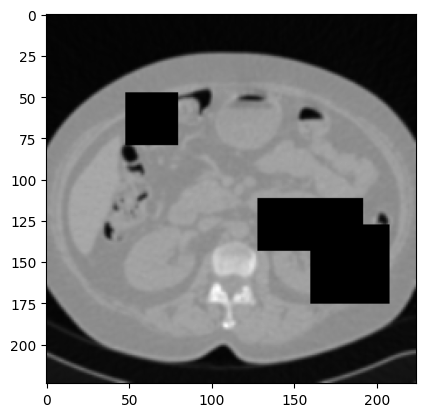

In [153]:
plot_one_slice(corrupted_crops[0].squeeze(0)[0], cmap='gray')

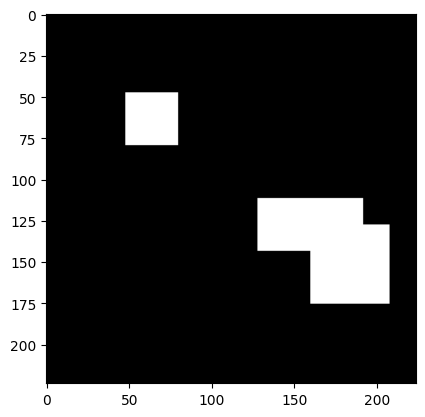

In [154]:
plot_one_slice(masks_crops[0].squeeze(0)[0], cmap='gray')

---

## Test

* **Q:** PatchEmbed class get images as batch but output dimension is for one image, is that correct?! Also, the output of the RECHead is for batch.

In [218]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        print(self.proj(x).shape)
        print(self.proj(x).flatten(2).shape)
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [216]:
class RECHead(nn.Module):
    def __init__(self, in_dim, in_chans=1, patch_size=16):
        super().__init__()

        layers = [nn.Linear(in_dim, in_dim)]
        layers.append(nn.GELU())
        layers.append(nn.Linear(in_dim, in_dim))
        layers.append(nn.GELU())
        layers.append(nn.Linear(in_dim, in_dim))
        layers.append(nn.GELU())

        self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        
        self.convTrans = nn.ConvTranspose2d(in_dim, in_chans, kernel_size=(patch_size, patch_size), 
                                                stride=(patch_size, patch_size))


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        print(x.shape) 
        x_rec = x.transpose(1, 2)
        print(x_rec.shape)
        out_sz = tuple( (  int(math.sqrt(x_rec.size()[2]))  ,   int(math.sqrt(x_rec.size()[2])) ) )
        print(out_sz)
        x_rec = self.convTrans(x_rec.unflatten(2, out_sz))
                
                
        return x_rec


In [219]:
pathch_embed = PatchEmbed(img_size=224, patch_size=16, in_chans=1, embed_dim=64)

In [206]:
output_img_tensor = output_volume_tensor.squeeze(0).squeeze(0)[0]
output_img_tensor = output_img_tensor.unsqueeze(0).unsqueeze(0)

In [220]:
projection_2d = pathch_embed.forward(output_img_tensor.float())

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 196])


In [208]:
projection_2d.shape

torch.Size([1, 196, 64])

In [217]:
RECHead(64).forward(projection_2d).shape

torch.Size([1, 196, 64])
torch.Size([1, 64, 196])
(14, 14)


torch.Size([1, 1, 224, 224])

----